In [1]:
from datasets import load_dataset
from collections import Counter
import torch

In [2]:
assert torch.cuda.is_available() == True

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)['full']

In [4]:
def add_sentiment(row):
    if row["rating"] >= 4:
        row["sentiment"] = "Positive"
    elif row["rating"] == 3:
        row["sentiment"] = "Neutral"
    else:
        row["sentiment"] = "Negative"
    return row

# Add sentiment column
dataset = dataset.map(add_sentiment, num_proc=7)

In [5]:
# Transform text to lowercase
dataset = dataset.map(lambda row: {"text": row["text"].lower()}, num_proc=7)

In [6]:
# Keep only the "sentiment" and "text" features
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ["sentiment", "text"]])

In [7]:
cnt = Counter(''.join(dataset['text']))
chars_to_remove = []
for char, count in sorted(cnt.items()):
    if count < 100:
        chars_to_remove.append(char)

In [ ]:
dict_trans = str.maketrans('', '', ''.join(chars_to_remove))
# Function for processing each row
def remove_chars(row, dict_trans):
    return {"text": row["text"].translate(dict_trans)}

# Use `fn_kwargs` to pass `dict_trans` explicitly
dataset = dataset.map(remove_chars, fn_kwargs={"dict_trans": dict_trans}, num_proc=7)

In [9]:
dataset = dataset.map(lambda row: {"len_text": len(row['text'])}, num_proc=7)

Map (num_proc=7):   0%|          | 0/701528 [00:00<?, ? examples/s]

In [12]:
from transformers import DistilBertModel, DistilBertTokenizerFast
model = DistilBertModel.from_pretrained("distilbert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [54]:
dataset = dataset.filter(lambda row: (row['len_text'] < 400) & (row['len_text'] >= 5), num_proc=7)

Filter (num_proc=7):   0%|          | 0/635430 [00:00<?, ? examples/s]

In [56]:
def tokenize(row, tokenizer):
    return tokenizer(row['text'], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=False, fn_kwargs={"tokenizer": tokenizer}, num_proc=7)

Map (num_proc=7):   0%|          | 0/627959 [00:00<?, ? examples/s]

OSError: [Errno 28] No space left on device

In [ ]:
dataset = dataset.remove_columns(['attention_mask'])

In [ ]:
dataset = dataset.rename_columns({'input_ids': "tokens"})

In [ ]:
dataset = dataset.map(lambda row: {'n_tokens': len(row['tokens'])}, num_proc=7)

Map (num_proc=7):   0%|          | 0/635430 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.filter(lambda row: row['n_tokens'] <= 128, num_proc=7)

121

In [ ]:
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']
test_dataset = test_valid_split['test']
valid_dataset = test_valid_split['train']

In [ ]:
train_dataset.save_to_disk('DATA/ds_train')
valid_dataset.save_to_disk('DATA/ds_valid')
test_dataset.save_to_disk('DATA/ds_test')

Saving the dataset (0/1 shards):   0%|          | 0/508344 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/63543 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/63543 [00:00<?, ? examples/s]

In [ ]:
sample = dataset.shuffle(seed=42).select(range(10000))
sample = sample.filter(lambda row: row['len_text'] < 400)
sample = sample.map(lambda row: tokenizer(row['text'], padding=True, truncation=True), batched=False)
sample = sample.map(lambda row: {'n_tokens': len(row['input_ids'])})

Map:   0%|          | 0/9056 [00:00<?, ? examples/s]

Map:   0%|          | 0/9056 [00:00<?, ? examples/s]

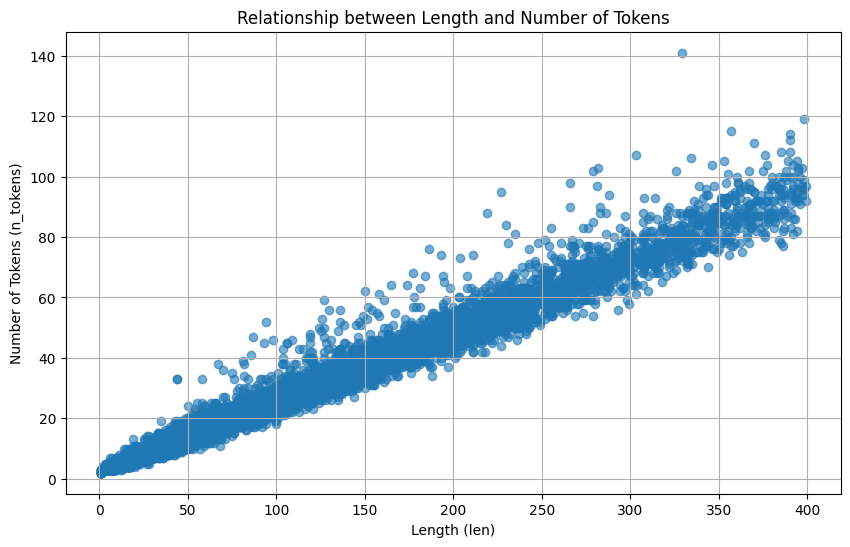

In [15]:
import matplotlib.pyplot as plt

len_values = sample["len_text"]
n_tokens_values = sample["n_tokens"]

plt.figure(figsize=(10, 6))
plt.scatter(len_values, n_tokens_values, alpha=0.6)
plt.title("Relationship between Length and Number of Tokens")
plt.xlabel("Length (len)")
plt.ylabel("Number of Tokens (n_tokens)")
plt.grid(True)
plt.show()
